In [1]:
import os
import re
import math
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
# Add utils to this notebook's sys path
import sys; sys.path.insert(0, str(Path("../scripts/").resolve()))
import utils

## Constants

_Choose which dataset to plot results here!_

In [3]:
### ACS datasets:
DATASET = "ACSIncome"
# DATASET = "ACSEmployment"
# DATASET = "ACSTravelTime"
# DATASET = "ACSPublicCoverage"
# DATASET = "ACSMobility"

### Others:
# DATASET = "MEPS"

In [4]:
# Number of trials that we want to use
N_TRIALS = 50
SEED = 21

In [5]:
SHOW_DATA_TYPE = "test"               # Data to show in plots
# SHOW_DATA_TYPE = "validation"         # Use to plot validation results
SELECT_ON_DATA_TYPE = "validation"    # Data to use for model selection

PERFORMANCE_METRIC = "accuracy"
DISPARITY_METRIC = "equalized_odds_diff"

FIT_POSTPROC_ON_DATA_TYPE = "validation"   # will be updated to train if no validation data is available

## Load task results

In [6]:
home_results_dir = Path("../results").resolve()

In [7]:
if "acs" in DATASET.lower():
    home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=4_2023-09-06"
    # home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=2_2023-09-06"
elif "meps" in DATASET.lower():
    home_results_dir /= "MEPS_T5.6-results_train_23380_test_15675_val_10020_3-groups_2023-09-08"
else:
    raise NotImplementedError(f"Dataset '{DATASET}' is not recognized.")

In [8]:
# Path to aggregated results file
task_df_path = home_results_dir / f"{DATASET}.{N_TRIALS}-trials.csv"

print(f"Loading experiments for {DATASET} dataset from '{task_df_path}'\n")
task_df = pd.read_csv(task_df_path, index_col=0, keep_default_na=False)

print(f"task_df.shape={task_df.shape}")
task_df.head(3)

Loading experiments for ACSIncome dataset from '/lustre/home/acruz/t5.6-supp-materials/results/ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=4_2023-09-06/ACSIncome.50-trials.csv'

task_df.shape=(1000, 767)


,original_test_accuracy,original_test_accuracy_diff,original_test_accuracy_diff_high-percentile,original_test_accuracy_diff_low-percentile,original_test_accuracy_diff_mean,original_test_accuracy_diff_stdev,original_test_accuracy_high-percentile,original_test_accuracy_low-percentile,original_test_accuracy_mean,original_test_accuracy_ratio,...,one_hot,base_model,meta_model,preprocessor_model,results_dir_path,results_json_path,model_pkl_path,unadjusted_pkl_path,expID,intervention
ACSIncome_base=lightgbm_meta=fairlearn-GS_equal-odds-constraint_preprocessor=None_one-hot=False_seed=26218916_hash=a34ed80b_2023.09.06-14.51,0.744541,0.274786,0.283394,0.262924,0.274291,0.004828,0.746105,0.743018,0.744561,0.666325,...,False,GBM,GS,None,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"GBM, GS",GS
ACSIncome_base=skorch-NN_meta=None_preprocessor=aif360-LFR_one-hot=True_seed=748051385_hash=5b7d565c_2023.09.06-21.44,0.753566,0.083896,0.092331,0.075001,0.083683,0.004352,0.755075,0.752094,0.753549,0.897919,...,True,NN,None,LFR,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"NN, LFR",LFR
ACSIncome_base=lightgbm_meta=None_preprocessor=aif360-LFR_one-hot=True_seed=523484801_hash=486fd14d_2023.09.06-19.11,0.707643,0.116491,0.124365,0.106229,0.116030,0.004601,0.709336,0.706151,0.707807,0.854481,...,True,GBM,None,LFR,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"GBM, LFR",LFR


In [9]:
# Images directory
imgs_dir = Path("../imgs").resolve() / home_results_dir.name
imgs_dir.mkdir(exist_ok=True)

def save_fig(fig, fig_name: str, data_type: str = SHOW_DATA_TYPE):
    fig_name = f"{DATASET}.{fig_name}.{data_type}"
    fig.savefig(imgs_dir / f"{fig_name}.png", bbox_inches="tight")
    fig.savefig(imgs_dir / f"{fig_name}.pdf", bbox_inches="tight")

Maximum accuracy for a dummy constant classifier on each of these datasets:

In [10]:
max_const_acc = {
    
    # MEPS w/ 3 groups
    "MEPS": {
        "train": 0.8289136013686912,
        "test": 0.8323444976076555,
        "validation": 0.8261477045908183,
    },
    
    # ACS datasets w/ 4 groups
    "ACSIncome": {
        "train": 0.6276484057384071,
        "test": 0.6267948098880045,
        "validation": 0.6275487157120827
    },
    "ACSPublicCoverage": {
        "train": 0.705777716173447,
        "test": 0.7080615054796799,
        "validation": 0.7048998544597685
    },
    "ACSMobility": {
        "train": 0.7366843896876353,
        "test": 0.7369037614281713,
        "validation": 0.7358002054311933
    },
    "ACSEmployment": {
        "train": 0.5401004328892394,
        "test": 0.5415303116248027,
        "validation": 0.5397890715398488
    },
    "ACSTravelTime": {
        "train": 0.5622398192707292,
        "test": 0.5624768352647576,
        "validation": 0.5620214827548473
    },
    
    # ACS datasets w/ 2 groups
    "ACSIncome_2-groups": {
        "train": 0.6241850824111531,
        "test": 0.6235629798713427,
        "validation": 0.6248460953171474
    },
    "ACSPublicCoverage_2-groups": {
        "train": 0.705911281940385,
        "test": 0.7057204742123492,
        "validation": 0.7054798103987695
    },
    "ACSMobility_2-groups": {
        "train": 0.7357699820802996,
        "test": 0.7340249324383227,
        "validation": 0.7358240182878397
    },
    "ACSEmployment_2-groups": {
        "train": 0.5427848119370537,
        "test": 0.5421000690106448,
        "validation": 0.5429492932666349
    },
    "ACSTravelTime_2-groups": {
        "train": 0.5700311069059425,
        "test": 0.5691778590020926,
        "validation": 0.57097203519255
    },
}

DATASET_ID = DATASET + ("_2-groups" if "max-groups=2" in home_results_dir.name else "")
task_const_pred_acc = max_const_acc[DATASET_ID][SHOW_DATA_TYPE]

print(f"'{DATASET_ID}' max. const. acc. on {SHOW_DATA_TYPE} is {task_const_pred_acc:.2%}")

'ACSIncome' max. const. acc. on test is 62.68%


**Check number of experiments per algorithm type.**

In [11]:
# Identifier columns (some are still redundant, yes)
exp_id_cols = ["base_model", "intervention", "meta_model", "preprocessor_model", "one_hot"]

num_seeds = task_df.groupby(exp_id_cols)["seed"].nunique()

print(num_seeds.to_string())
print(f"Number of unique experiments: {num_seeds.sum()}")

base_model  intervention  meta_model  preprocessor_model  one_hot
GBM         CR            None        CR                  True       50
            EG            EG          None                False      50
            FairGBM       None        None                False      50
            GS            GS          None                False      50
            LFR           None        LFR                 True       50
            None          None        None                False      50
LR          CR            None        CR                  True       50
            EG            EG          None                True       50
            GS            GS          None                True       50
            LFR           None        LFR                 True       50
            None          None        None                True       50
NN          CR            None        CR                  True       50
            EG            EG          None                True       5

---
# Plotting utils and parameters

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

sns.set(style="whitegrid", palette="colorblind", rc={"grid.linestyle": "--"})

In [13]:
base_model_labels_sort = task_df["base_model"].unique().tolist()
base_model_labels_sort = sorted(base_model_labels_sort)

base_model_to_color_map = dict(zip(base_model_labels_sort, sns.color_palette("colorblind")))
palette = [base_model_to_color_map[bm] for bm in base_model_labels_sort]

print(f"Order of base model labels: {base_model_labels_sort}")

Order of base model labels: ['GBM', 'LR', 'NN', 'RF']


In [14]:
full_palette = sns.color_palette("colorblind", n_colors=7)
full_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236)]

In [15]:
intervention_labels_sort = sorted(task_df["intervention"].unique().tolist())

# Set "None" (no intervention) in the beginning and "FairGBM" at the end (as it only applies to GBM)
intervention_labels_sort.remove("None")
intervention_labels_sort.remove("FairGBM")
intervention_labels_sort = ["None"] + intervention_labels_sort + ["FairGBM"]

intervention_labels_markers = ["o", (4, 0, 0), "P", "X", (5, 1, 0), "^"]
intervention_to_marker_map = dict(zip(intervention_labels_sort, intervention_labels_markers))

print(intervention_labels_sort)

['None', 'CR', 'EG', 'GS', 'LFR', 'FairGBM']


In [16]:
def compute_expID_sort_key(expID: str) -> int:

    # Sort by base_model first
    base_key = [
        idx 
        for idx, bmodel in enumerate(base_model_labels_sort) 
        if bmodel in expID
    ][0]
    
    # Then sort by intervention
    interv_key = [
        idx
        for idx, interv in enumerate(intervention_labels_sort)
        if interv in expID
    ]

    # Put unconstrained methods first
    interv_key = interv_key[0] if interv_key else -1

    return base_key * 100 + interv_key

exp_id_labels_sort = sorted(
    task_df["expID"].unique().tolist(),
    key=compute_expID_sort_key,
)

print(exp_id_labels_sort)

['GBM', 'GBM, CR', 'GBM, EG', 'GBM, GS', 'GBM, LFR', 'FairGBM', 'LR', 'LR, CR', 'LR, EG', 'LR, GS', 'LR, LFR', 'NN', 'NN, CR', 'NN, EG', 'NN, LFR', 'RF', 'RF, CR', 'RF, EG', 'RF, GS', 'RF, LFR']


In [17]:
# Some global plot settings
plt.rc(
    "figure",
    figsize=(10, 3),
    dpi=200,
)

ax_kwargs = dict(
    title=f"{DATASET} ({SHOW_DATA_TYPE})",
    xlabel=PERFORMANCE_METRIC,
    ylabel="constraint violation",
#     ylabel="fairness violation",
#     ylabel="equal odds diff.",
)

# zoomed in axes range
plot_ax_lim_per_task = {

    # ACS datasets w/ 3 groups
    "MEPS": dict(
        xlim=(0.84, 0.8655),
        ylim=(0.0, 0.12),
    ),
    
    # ACS datasets w/ 4 groups
    "ACSIncome": dict(
        xlim=(0.78, 0.83),
        ylim=(0.0, 0.7),
    ),

    "ACSEmployment": dict(
        xlim=(0.8225, 0.8331),
        ylim=(0.0, 0.105),
    ),

    "ACSMobility": dict(
        xlim=(0.758, 0.7724),
        ylim=(0.0, 0.2),
    ),

    "ACSPublicCoverage": dict(
        xlim=(0.79, 0.81),
        ylim=(0.0, 0.4),
    ),

    "ACSTravelTime": dict(
        xlim=(0.66, 0.72),
        ylim=(0.0, 0.2),
    ),
    
    # ACS datasets w/ 2 groups
    "ACSIncome_2-groups": dict(
        xlim=(0.8, 0.82),
        ylim=(0.0, 0.25),
    ),

    "ACSEmployment_2-groups": dict(
        xlim=(0.825, 0.834),
        ylim=(0.0, 0.03),
    ),

    "ACSMobility_2-groups": dict(
        xlim=(0.75, 0.771),
        ylim=(0.0, 0.06),
    ),

    "ACSPublicCoverage_2-groups": dict(
        xlim=(0.79, 0.813),
        ylim=(0.0, 0.16),
    ),

    "ACSTravelTime_2-groups": dict(
        xlim=(0.66, 0.72),
        ylim=(0.0, 0.1),
    ),
}

ax_kwargs.update(plot_ax_lim_per_task.get(DATASET_ID, plot_ax_lim_per_task[DATASET]))

---

In [18]:
def get_results(
        model_type: str,
        data_type: str = "test",
    ) -> pd.DataFrame:
    assert model_type in ("original", "unadjusted")
    assert data_type in ("test", "validation", "validation-solution")

    col_prefix = f"{model_type}_{data_type}"

    # Use bootstrap means
    perf_col = f"{col_prefix}_{PERFORMANCE_METRIC}_mean"
    disp_col = f"{col_prefix}_{DISPARITY_METRIC}_mean"

    # # Use as-is test sample means
    # perf_col = f"{col_prefix}_{PERFORMANCE_METRIC}"
    # disp_col = f"{col_prefix}_{DISPARITY_METRIC}"

    return task_df[
        exp_id_cols + ["expID", perf_col, disp_col]
    ].rename(
        columns={
            perf_col: PERFORMANCE_METRIC,
            disp_col: DISPARITY_METRIC,
            "base_model": "base model",
            "intervention": "fairness method",
#             "intervention": "fairness interv.",
        }
    )

---
# Plotting real-data version of illustrative plot

Three plots/panels side-by-side, with:
1. All original results for two algorithms;
    - and select one model of each algorithm type for next panels;
2. Plot unprocessed results for the two algorithms,
    - with visible mapping for the two selected models;
3. Postprocessing of both models;
    - or maybe just show postprocessing for the best unprocessed model among the two;

In [19]:
ALGO_TYPE_PERF = "GBM"
# ALGO_TYPE_PERF = "RF"

ALGO_TYPE_FAIR = "RF, EG"
# ALGO_TYPE_FAIR = "GBM, EG"
# ALGO_TYPE_FAIR = "NN, CR"

In [20]:
xlim = ax_kwargs["xlim"]
ylim = ax_kwargs["ylim"]

if DATASET == "ACSIncome":
    if ALGO_TYPE_FAIR == "GBM, LFR":
        xlim = [0.65, 0.845]
        ylim = [0, 0.8]

    elif ALGO_TYPE_FAIR == "GBM, EG":
        xlim = [0.81, 0.824]
        ylim = [0, 0.6]
    
    elif ALGO_TYPE_FAIR == "RF, EG":
        if ALGO_TYPE_PERF == "RF":
            xlim = [0.797, 0.815]
            ylim = [0, 0.65]

        elif ALGO_TYPE_PERF == "GBM":
            xlim = [0.785, 0.83]
            ylim = [0, 0.65]
    
    elif ALGO_TYPE_FAIR == "NN, CR":
        if ALGO_TYPE_PERF == "RF":
            xlim = [0.78, 0.817]
            ylim = [0, 0.7]

        elif ALGO_TYPE_PERF == "GBM":
            xlim = [0.785, 0.83]
            ylim = [0, 0.7]

In [21]:
# Filter to keep only models from the two studied algorithm types
algo_types_filter = (
    (task_df["expID"] == ALGO_TYPE_PERF)
    | (task_df["expID"] == ALGO_TYPE_FAIR)
)

orig_results = get_results("original", SHOW_DATA_TYPE)[algo_types_filter]
unpr_results = get_results("unadjusted", SHOW_DATA_TYPE)[algo_types_filter]
assert len(orig_results) == len(unpr_results) == N_TRIALS * 2

# Filter out results that are worse than dummy classifier?
# orig_results = orig_results[orig_results[PERFORMANCE_METRIC] >= task_const_pred_acc + 1e-3]
# unpr_results = unpr_results[unpr_results[PERFORMANCE_METRIC] >= task_const_pred_acc + 1e-3]

In [22]:
# Original results for the 'perf' and the 'fair' algorithm types
orig_perf_algo_results = orig_results[orig_results["expID"] == ALGO_TYPE_PERF]
orig_fair_algo_results = orig_results[orig_results["expID"] == ALGO_TYPE_FAIR]

# Unprocessed results for both algorithm types
unpr_perf_algo_results = orig_results[unpr_results["expID"] == ALGO_TYPE_PERF]
unpr_fair_algo_results = orig_results[unpr_results["expID"] == ALGO_TYPE_FAIR]

**Select** on validation one model of each algorithm type based on different fairness preferences:

In [23]:
# Select 'perf' model type based on unprocessed performance
best_perf_model_row = task_df[(task_df["expID"] == ALGO_TYPE_PERF)].sort_values(
    f"unadjusted_{SELECT_ON_DATA_TYPE}_{PERFORMANCE_METRIC}",
    ascending=False,
).iloc[0]

print(f"Best perf. {ALGO_TYPE_PERF} model: {best_perf_model_row.name}")

Best perf. GBM model: ACSIncome_base=lightgbm_meta=None_preprocessor=None_one-hot=False_seed=865235990_hash=1eaaca2f_2023.09.06-14.23


In [24]:
# Select 'fair' model type based on a weighing of fairness and performance
# FAIRNESS_WEIGHT = 0.5
FAIRNESS_WEIGHT = 0.25

col_name = f"{FAIRNESS_WEIGHT}-fair_{1-FAIRNESS_WEIGHT:.2}-perf"
fair_model_selection_rows = task_df[(task_df["expID"] == ALGO_TYPE_FAIR)]
fair_model_select_col = (
    (1 - FAIRNESS_WEIGHT) * fair_model_selection_rows[f"original_{SELECT_ON_DATA_TYPE}_{PERFORMANCE_METRIC}"]
    - FAIRNESS_WEIGHT * fair_model_selection_rows[f"original_{SELECT_ON_DATA_TYPE}_{DISPARITY_METRIC}"]
)

best_fair_model_row = task_df.loc[fair_model_select_col.sort_values(ascending=False).index[0]]

print(f"Best fair. {ALGO_TYPE_FAIR} model: {best_fair_model_row.name}")

Best fair. RF, EG model: ACSIncome_base=random-forest_meta=fairlearn-EG_equal-odds-constraint_preprocessor=None_one-hot=False_seed=705131364_hash=e63bcfb0_2023.09.06-15.12


---
_**Helper functions for adjustment/postprocessing curve**_

In [25]:
from utils import MODEL_PREDICTIONS_VALIDATION
from utils.postprocessing import load_or_compute_adjustment_curve
from utils.models import compute_model_predictions

def compute_adjustment_curve_helper(model, exp_dir, all_data, **kwargs):
    X_val, y_val, s_val = all_data["validation"]
    predictions_save_path = exp_dir / MODEL_PREDICTIONS_VALIDATION

    y_scores_val = compute_model_predictions(
        model, X_val, s_val,
        predictions_save_path=predictions_save_path,
    )

    global FIT_POSTPROC_ON_DATA_TYPE
    FIT_POSTPROC_ON_DATA_TYPE = "validation" if "validation" in all_data else "train"

    adjustment_results_df = load_or_compute_adjustment_curve(
        model=model,
        exp_dir=exp_dir,
        fit_data=all_data.get(FIT_POSTPROC_ON_DATA_TYPE),
        y_fit_pred_scores=y_scores_val,
        eval_data={
            "validation": all_data["validation"],
            "test": all_data["test"],
        },
        n_jobs=max(1, os.cpu_count() - 1),
        fairness_constraint="equalized_odds",
        tolerance_ticks=np.hstack((
            np.arange(0.0, 0.5, 1e-2),
            np.arange(0.5, 1.0, 1e-1),
        )),
        **kwargs,
    )

    return adjustment_results_df

In [26]:
from utils.notebook import load_experiment_data, load_or_refit_experiment_model
from error_parity.pareto_curve import compute_inner_and_outer_adjustment_ci, get_envelope_of_postprocessing_frontier

def get_adjustment_curve_from_model_row(model_row, use_precomputed_curve=True):
    """Helper to load or compute adjustment curve for the given model row in the results DF.
    """

    # Load (or compute) adjustment curve
    # > Load:
    adj_curve_path = (
        home_results_dir
        / "postprocessing-adjustment-curves"
        / model_row.name
        / "model-adjustment-curve.bootstrap.csv"
    )

    assert adj_curve_path.exists(), f"Couldn't find pre-computed results for '{model_row.name}' at '{adj_curve_path}'"
    adjustment_results_df = pd.read_csv(adj_curve_path, index_col=0)

    """
    # Else, compute and save to disk
    if not adj_curve_path.exists():
        print("Couldn't find pre-computed postprocessing results, will need to re-compute them...")

        # > Compute
        adjustment_results_df = compute_adjustment_curve_helper(
            model=model,
            exp_dir=exp_dir,
            all_data=all_data,
            bootstrap=True,
            load_if_available=use_precomputed_curve,
        )

        # > Save to disk
        adjustment_results_df.to_csv(adj_curve_path, index=True)
    """

    # Get adjustment frontier
    adjustment_frontier = get_envelope_of_postprocessing_frontier(
        adjustment_results_df,
        constant_clf_perf=task_const_pred_acc,
    )

    # Get inner and outer conf. interv. for adjustment frontier
    (
        adjustment_frontier_xticks,
        interior_frontier_yticks,
        outer_frontier_yticks,
    ) = compute_inner_and_outer_adjustment_ci(
            adjustment_results_df,
            perf_metric=PERFORMANCE_METRIC,
            disp_metric=DISPARITY_METRIC,
            data_type=SHOW_DATA_TYPE,
            constant_clf_perf=task_const_pred_acc,
        )

    return {
        "adjustment_results_df": adjustment_results_df,
        "adjustment_frontier": adjustment_frontier,
        "adjustment_frontier_xticks": adjustment_frontier_xticks,
        "interior_frontier_yticks": interior_frontier_yticks,
        "outer_frontier_yticks": outer_frontier_yticks,
    }

Compute postprocessing adjustment frontiers for selected models:

In [27]:
%%time
perf_model_adjustment_vars = get_adjustment_curve_from_model_row(best_perf_model_row)

CPU times: user 14.3 ms, sys: 3 ms, total: 17.3 ms
Wall time: 17.8 ms


In [28]:
SHOW_SCND_CURVE = True
# SHOW_SCND_CURVE = False

In [29]:
%%time
if SHOW_SCND_CURVE:
    fair_model_adjustment_vars = get_adjustment_curve_from_model_row(best_fair_model_row)

CPU times: user 16.6 ms, sys: 1.74 ms, total: 18.3 ms
Wall time: 18.2 ms


---

In [30]:
def plot_point(ax, x, y, **kwargs):
    kwargs.setdefault("marker", "o")
    kwargs.setdefault("zorder", 20)

    if "s" in kwargs:
        kwargs["ms"] = math.sqrt(kwargs.pop("s"))

    ax.plot(
        x, y,
        lw=0,
        markeredgecolor="white",
        markeredgewidth=1,
        **kwargs,
    )

def plot_hline(ax, y, text):
    ax.axhline(
        y=y,
        ls="--",
        color="grey",
    )

    ax.annotate(
        text,
        color="grey",
        xy=(4e-2, y + 2e-2),
    )

In [31]:
# Base model and type of intervention
algo_type_perf_base = best_perf_model_row["base_model"]
algo_type_perf_interv = best_perf_model_row["intervention"]

algo_type_fair_base = best_fair_model_row["base_model"]
algo_type_fair_interv = best_fair_model_row["intervention"]

# Marker style and color
perf_model_color = base_model_to_color_map[algo_type_perf_base]
fair_model_color = base_model_to_color_map[algo_type_fair_base] if algo_type_fair_base != algo_type_perf_base else full_palette[4]

perf_model_marker = intervention_to_marker_map[algo_type_perf_interv]
fair_model_marker = intervention_to_marker_map[algo_type_fair_interv]

# Default kwargs to be used by most plots
scatterplot_kwargs = dict(
    x=PERFORMANCE_METRIC,
    y=DISPARITY_METRIC,
    hue="expID",
    style="expID",

    hue_order=[ALGO_TYPE_PERF, ALGO_TYPE_FAIR],
    style_order=[ALGO_TYPE_PERF, ALGO_TYPE_FAIR],

    palette=[
        perf_model_color,
        fair_model_color,
    ],

    markers=[
        perf_model_marker,
        fair_model_marker,
    ],
)

legend_kwargs = dict(
    bbox_to_anchor=(1.03, 1),
    loc="upper left",
    borderaxespad=0,
)

---
**Plot with three panels:**

In [32]:
model_label_c = 0.02 * (xlim[1] - xlim[0])
# model_label_c = 1.5e-3
model_label_jitter = np.array([model_label_c, -2.5 * model_label_c * ((ylim[1] - ylim[0]) / (xlim[1] - xlim[0]))])

orig_results_perf_model = orig_results.loc[best_perf_model_row.name]
orig_results_fair_model = orig_results.loc[best_fair_model_row.name]

unpr_results_perf_model = unpr_results.loc[best_perf_model_row.name]
unpr_results_fair_model = unpr_results.loc[best_fair_model_row.name]

# Original points
point_A = np.array([orig_results_perf_model[PERFORMANCE_METRIC], orig_results_perf_model[DISPARITY_METRIC]])
point_B = np.array([orig_results_fair_model[PERFORMANCE_METRIC], orig_results_fair_model[DISPARITY_METRIC]])

# Unprocessed points
# > Using highest accuracy point of postprocessing curve:
point_A_unproc = perf_model_adjustment_vars["adjustment_frontier"][np.argmax(perf_model_adjustment_vars["adjustment_frontier"][:, 0])]

if SHOW_SCND_CURVE:
    point_B_unproc = fair_model_adjustment_vars["adjustment_frontier"][np.argmax(fair_model_adjustment_vars["adjustment_frontier"][:, 0])]
else:
    point_B_unproc = np.array([unpr_results_fair_model[PERFORMANCE_METRIC], unpr_results_fair_model[DISPARITY_METRIC]])
    
# > Using saved unprocessing results:
# point_A_unproc = np.array([unpr_results_perf_model[PERFORMANCE_METRIC], unpr_results_perf_model[DISPARITY_METRIC]])
# point_B_unproc = np.array([unpr_results_fair_model[PERFORMANCE_METRIC], unpr_results_fair_model[DISPARITY_METRIC]])

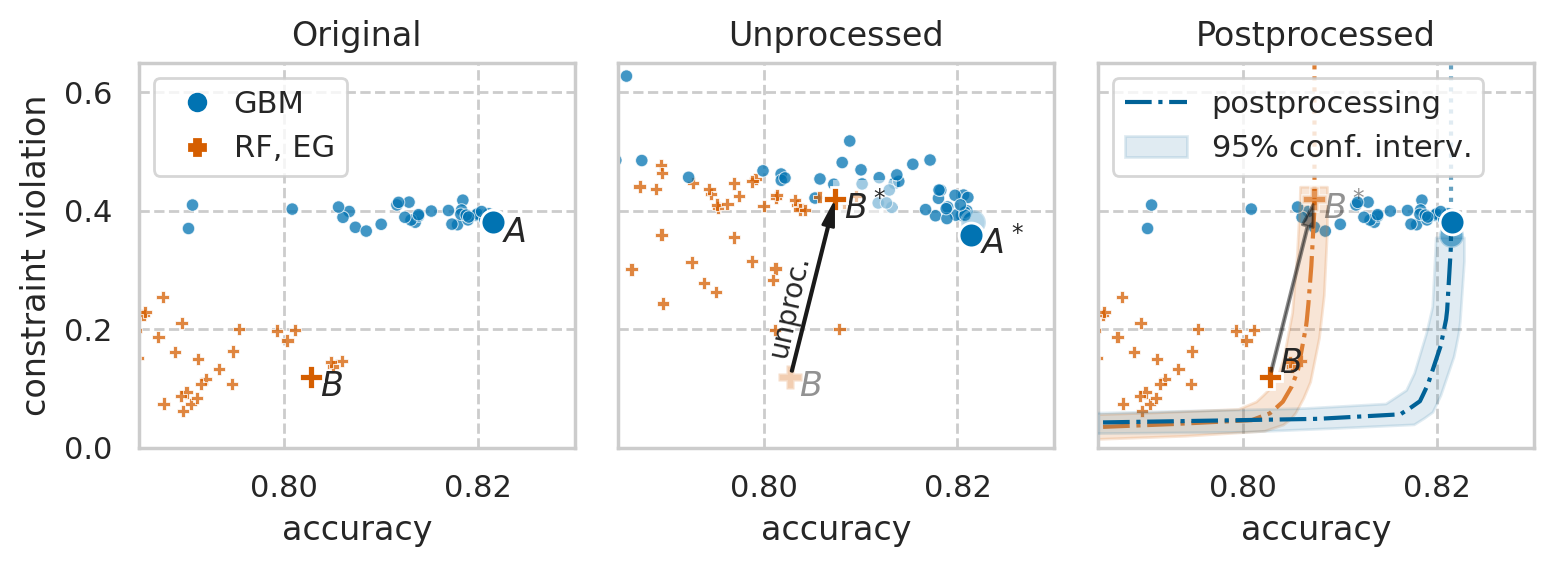

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(9, 2.5), gridspec_kw=dict(wspace=0.1))
    
# Arrow style
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
arrow_kw = dict(arrowstyle=style, color="k", zorder=20)

BKG_MARKER_SIZE = 20
FRG_MARKER_SIZE = 80

### ### ######## ### ###
### ### 1st PLOT ### ###
### ### ######## ### ###

# Plot all background points
sns.scatterplot(
    data=orig_results,
    ax=ax1,
    alpha=0.75,
    s=BKG_MARKER_SIZE,
    **scatterplot_kwargs,
)

# Plot selected models
# > Model A -> 'perf' model
plot_point(
    ax1, *point_A,
    color=perf_model_color,
    marker=perf_model_marker,
    s=FRG_MARKER_SIZE,
)
ax1.annotate(
    r"$A$",
    xy=point_A,
    xytext=point_A + model_label_jitter,
)

# > Model B -> 'fair' model
plot_point(
    ax1, *point_B,
    color=fair_model_color,
    marker=fair_model_marker,
    s=FRG_MARKER_SIZE,
)
ax1.annotate(
    r"$B$",
    xy=point_B,
    xytext=point_B + model_label_jitter,
)


### ### ######## ### ###
### ### 2nd PLOT ### ###
### ### ######## ### ###

# Plot *unprocessed* background points
sns.scatterplot(
    data=unpr_results,
    ax=ax2,
    alpha=0.75,
    s=BKG_MARKER_SIZE,
    **scatterplot_kwargs,
)

# Plot original models A and B
# > og. point A
plot_point(
    ax2, *point_A,
    color=perf_model_color,
    marker=perf_model_marker,
    s=FRG_MARKER_SIZE,
    alpha=0.3,
)
# ax2.annotate(
#     r"$A$",
#     xy=point_A,
#     xytext=point_A + model_label_jitter,
# )

# > og. point B
plot_point(
    ax2, *point_B,
    color=fair_model_color,
    marker=fair_model_marker,
    s=FRG_MARKER_SIZE,
    alpha=0.3,
)
ax2.annotate(
    r"$B$",
    xy=point_B,
    xytext=point_B + model_label_jitter,
    alpha=0.5,
)

# Plot unprocessed models A^* and B^*
plot_point(
    ax2, *point_A_unproc,
    color=perf_model_color,
    marker=perf_model_marker,
    s=FRG_MARKER_SIZE,
)
ax2.annotate(
    r"$A^*$",
    xy=point_A_unproc,
    xytext=point_A_unproc + model_label_jitter,
)

plot_point(
    ax2, *point_B_unproc,
    color=fair_model_color,
    marker=fair_model_marker,
    s=FRG_MARKER_SIZE,
)
ax2.annotate(
    r"$B^*$",
    xy=point_B_unproc,
    xytext=point_B_unproc + model_label_jitter,
    bbox=dict(facecolor='white', alpha=0.5, linewidth=0),
)

# Arrow from B to B unprocessed
arrow_B_Bstar = FancyArrowPatch(point_B, point_B_unproc, **arrow_kw)
ax2.add_patch(arrow_B_Bstar)

ax2.annotate(
    "unproc.",
    size=10,
    
    # > Default
    xy=(
        point_B
        + 0.06 * np.array([-(xlim[1] - xlim[0]), (ylim[1] - ylim[0])])
#         + (point_B_unproc - point_B) / 6
    ),
    rotation=(
        (180 / np.pi)
        * np.arctan(
            ((point_B_unproc[1] - point_B[1]) / (ylim[1] - ylim[0]))
            / ((point_B_unproc[0] - point_B[0]) / (xlim[1] - xlim[0]))
        )
    ),
    
    # > RF and NN-CR
#     rotation=67,

    # > General purpose coordinates
#     xy=(0.5, 0.5),
#     xycoords=arrow_B_Bstar,
#     ha="center",
#     va="center",
)


### ### ######## ### ###
### ### 3rd PLOT ### ###
### ### ######## ### ###

# Plot original background points
sns.scatterplot(
    data=orig_results,
    ax=ax3,
    alpha=0.75,
    s=BKG_MARKER_SIZE,
    **scatterplot_kwargs,
)

# Plot original selected models A and B
# > Point A
plot_point(
    ax3, *point_A,
    color=perf_model_color,
    marker=perf_model_marker,
    s=FRG_MARKER_SIZE,
)
# ax3.annotate(
#     r"$A$",
#     xy=point_A,
#     xytext=point_A + model_label_jitter,
# )

# > Point B
plot_point(
    ax3, *point_B,
    color=fair_model_color,
    marker=fair_model_marker,
    s=FRG_MARKER_SIZE,
)
ax3.annotate(
    r"$B$",
    xy=point_B,
    xytext=point_B + model_label_jitter * np.array([1, -0.2]),
)

### Plot postprocessing frontier for model A!
# > color for 1st curve is that if perf_model but slightly moved to black
a = np.array(perf_model_color)
# frst_curve_color = "black"
frst_curve_color = a * 0.85

globals().update({
    f"{var_name}_A": var_value
    for var_name, var_value in perf_model_adjustment_vars.items()
})

# Plot adjustment curve
sns.lineplot(
    x=adjustment_frontier_A[:, 0],
    y=adjustment_frontier_A[:, 1],
    label=r"postprocessing",
    linestyle="-.",
    color=frst_curve_color,
    ax=ax3,
    zorder=11,
)

# Draw upper right portion of the line (dominated but not feasible)
upper_right_frontier_A = np.array([
    adjustment_frontier_A[-1],
    (adjustment_frontier_A[-1, 0] - 1e-6, 1.0),
])

sns.lineplot(
    x=upper_right_frontier_A[:, 0],
    y=upper_right_frontier_A[:, 1],
    linestyle=":",
#     label=r"dominated by $m^*$",
    color=frst_curve_color,
    alpha=0.6,
    ax=ax3,
)

# Plot shaded area -> confidence intervals
ax3.fill_between(
    x=adjustment_frontier_xticks_A,
    y1=interior_frontier_yticks_A,
    y2=outer_frontier_yticks_A,
    interpolate=True,
    color=frst_curve_color,
    alpha=0.12,
    label=r"$95\%$ conf. interv.",
    zorder=11,
)


### Plot points A^* and B^*
plot_point(
    ax3, *point_A_unproc,
    color=perf_model_color,
    marker=perf_model_marker,
    s=FRG_MARKER_SIZE,
    alpha=0.6,
    zorder=5,
)
plot_point(
    ax3, *point_B_unproc,
    color=fair_model_color,
    marker=fair_model_marker,
    s=FRG_MARKER_SIZE,
    alpha=0.6,
    zorder=5,
)
ax3.annotate(
    r"$B^*$",
    xy=point_B_unproc,
    xytext=point_B_unproc + model_label_jitter,
    alpha=0.5,
)


if SHOW_SCND_CURVE:

    # Color for 2nd curve is that if fair_model but slightly moved to white
    a = np.array(fair_model_color)
    scnd_curve_color = a + 0.2 * (np.ones_like(a) - a)

    arrow_B_Bstar_transparent = FancyArrowPatch(point_B, point_B_unproc, alpha=0.5, **arrow_kw)
    ax3.add_patch(arrow_B_Bstar_transparent)

    ### Plot postprocessing frontier for model B!
    globals().update({
        f"{var_name}_B": var_value
        for var_name, var_value in fair_model_adjustment_vars.items()
    })

    # Plot adjustment curve
    sns.lineplot(
        x=adjustment_frontier_B[:, 0],
        y=adjustment_frontier_B[:, 1],
        linestyle="-.",
        color=scnd_curve_color,
        ax=ax3,
    )

    # Draw upper right portion of the line (dominated but not feasible)
    upper_right_frontier_B = np.array([
        adjustment_frontier_B[-1],
        (adjustment_frontier_B[-1, 0] - 1e-6, 1.0),
    ])

    sns.lineplot(
        x=upper_right_frontier_B[:, 0],
        y=upper_right_frontier_B[:, 1],
        linestyle=":",
    #     label=r"dominated by $m^*$",
        color=scnd_curve_color,
        ax=ax3,
    )

    # Plot shaded area -> confidence intervals
    ax3.fill_between(
        x=adjustment_frontier_xticks_B,
        y1=interior_frontier_yticks_B,
        y2=outer_frontier_yticks_B,
        interpolate=True,
        color=scnd_curve_color,
        alpha=0.2,
        label=r"$95\%$ conf. interv.",
    )


# Axes labels
ax1.set(ylabel="constraint violation")
ax1.set(xlabel="accuracy")
ax2.set(xlabel="accuracy")
ax3.set(xlabel="accuracy")

# Subplot titles
# ax1.set(title="Contender")
ax1.set(title="Original")
ax2.set(title="Unprocessed")

if SHOW_SCND_CURVE:
    ax3.set(title="Postprocessed")
else:
    ax3.set(title="Postprocessing $A^*$")

# Plot settings
ax1.set_ylim(*ylim)
ax1.set_xlim(*xlim)
ax2.set_xlim(*xlim)
ax3.set_xlim(*xlim)

# Which legends to remove and which to keep
ax1.legend(
    handles=[
        # Marker for 'perf' algo type
        Line2D(
            [0], [0],
            marker=perf_model_marker,
            color=perf_model_color,
            markersize=6, lw=0),
        # Marker for 'fair' algo type
        Line2D(
            [0], [0],
            marker=fair_model_marker,
            color=fair_model_color,
            markersize=6, lw=0),
    ],
    labels=[ALGO_TYPE_PERF, ALGO_TYPE_FAIR],
    loc="upper left",
    handletextpad=0.2,
)


ax2.legend().remove()

ax3_handles, ax3_labels = ax3.get_legend_handles_labels()

if SHOW_SCND_CURVE:
    ax3.legend(handles=ax3_handles[-3:-1], labels=ax3_labels[-3:-1], loc="upper left")
else:
    ax3.legend(handles=ax3_handles[-2:], labels=ax3_labels[-2:], loc="upper left")

# Save plot to disk
save_fig(
    fig,
    f"illustrative-plot-with-real-data.{ALGO_TYPE_PERF}-vs-{ALGO_TYPE_FAIR}.{FAIRNESS_WEIGHT}-alpha"
    + ("with-2nd-curve" if SHOW_SCND_CURVE else "")
)

plt.show()

##### 